In [1]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog

Image processing complete.
Total images: 1861
Training images: 1488
Validation images: 373

Label distribution:
0    995
1    866
Name: count, dtype: int64

Data balance (ratio of minority to majority class): 0.87


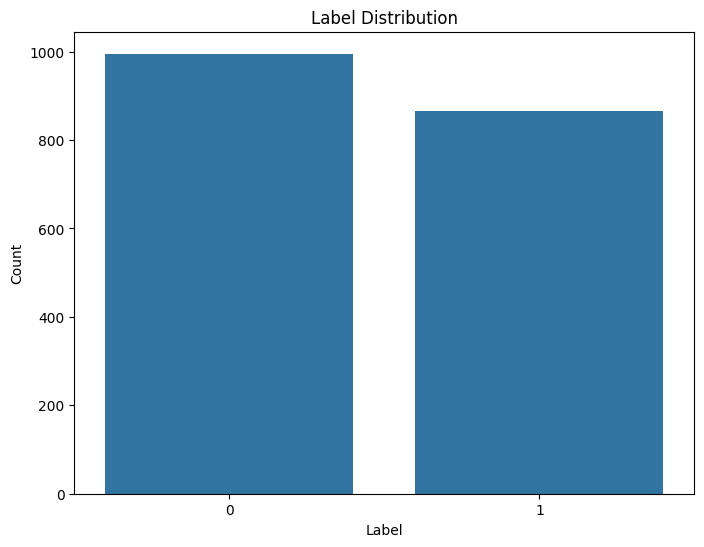

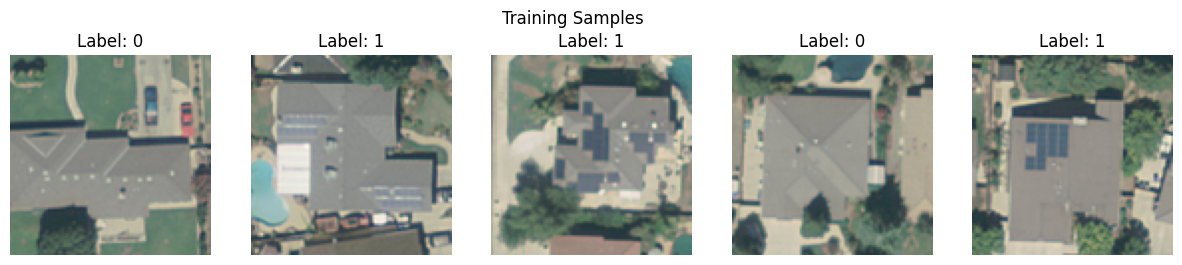

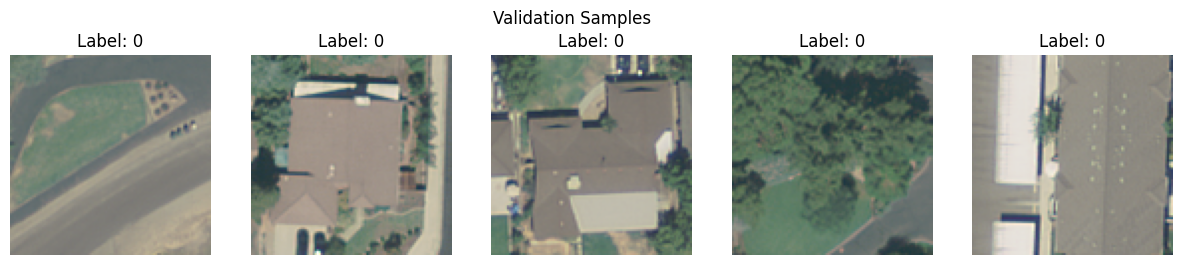

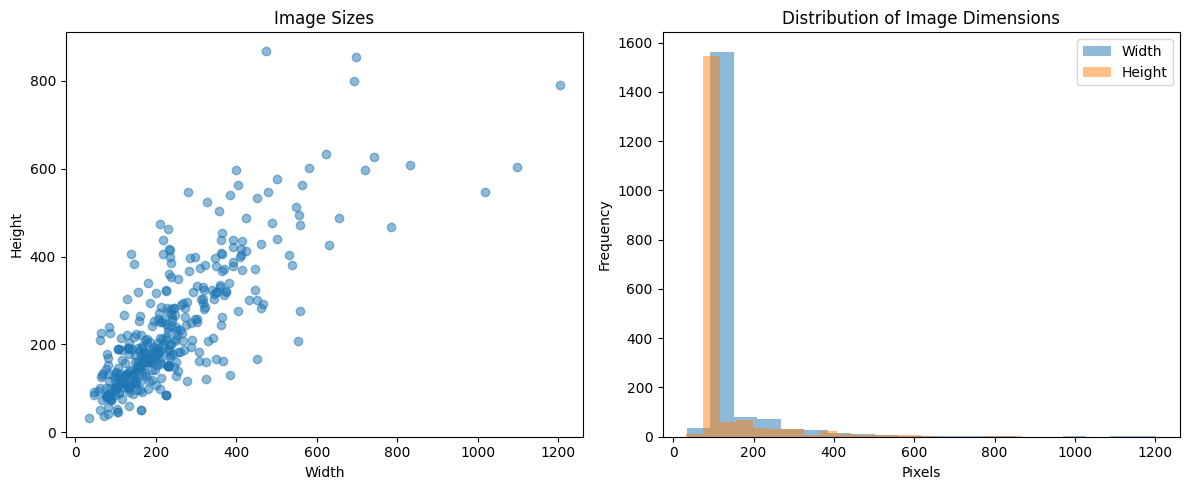


Image size statistics:
             width       height
count  1861.000000  1861.000000
mean    128.802794   127.563675
std      89.810831    83.250560
min      34.000000    32.000000
25%     101.000000   101.000000
50%     101.000000   101.000000
75%     101.000000   101.000000
max    1203.000000   868.000000


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.5308 - loss: 0.6710 - val_accuracy: 0.6944 - val_loss: 0.5910
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7224 - loss: 0.5479 - val_accuracy: 0.7131 - val_loss: 0.5391
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7365 - loss: 0.5093 - val_accuracy: 0.7051 - val_loss: 0.5447
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7406 - loss: 0.5082 - val_accuracy: 0.7078 - val_loss: 0.5431
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7352 - loss: 0.5057 - val_accuracy: 0.7105 - val_loss: 0.5373
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7467 - loss: 0.5007 - val_accuracy: 0.7078 - val_loss: 0.5414
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7348 - loss: 0.5077 - val_accuracy: 0.7105 - val_loss: 0.5388
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.7409 - loss: 0.4966 - val_accu

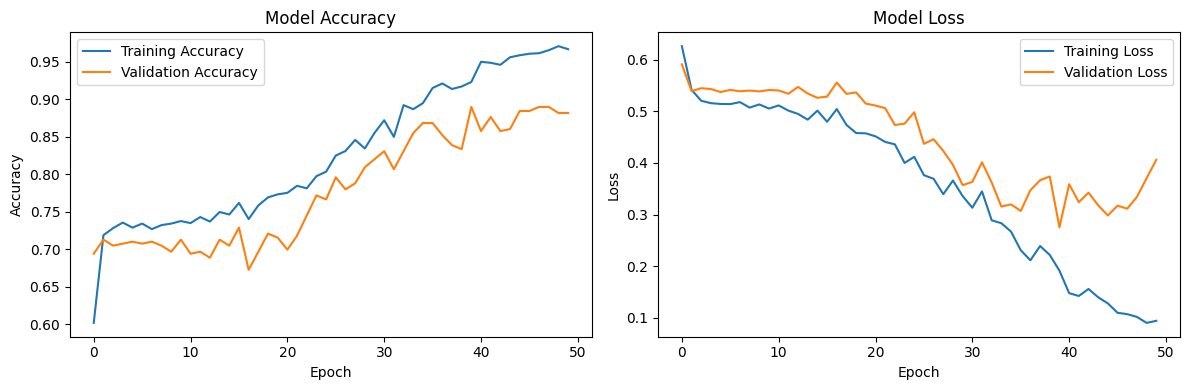

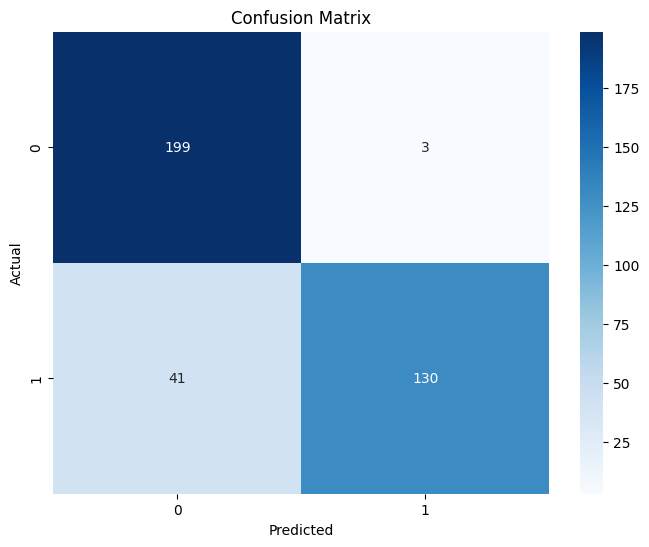

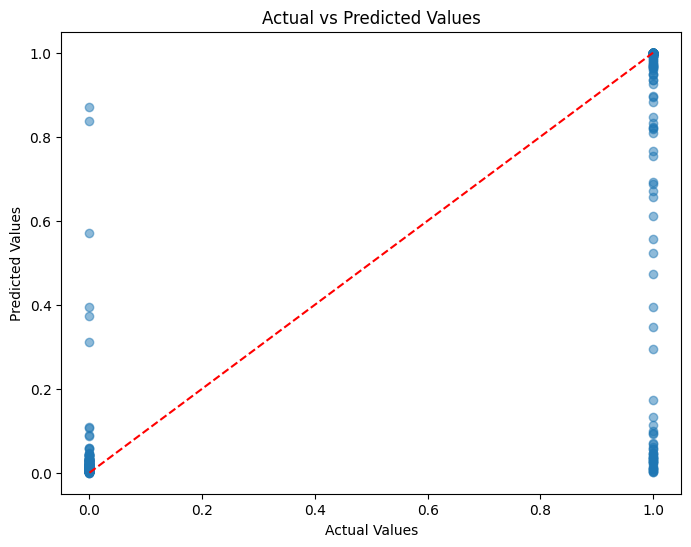

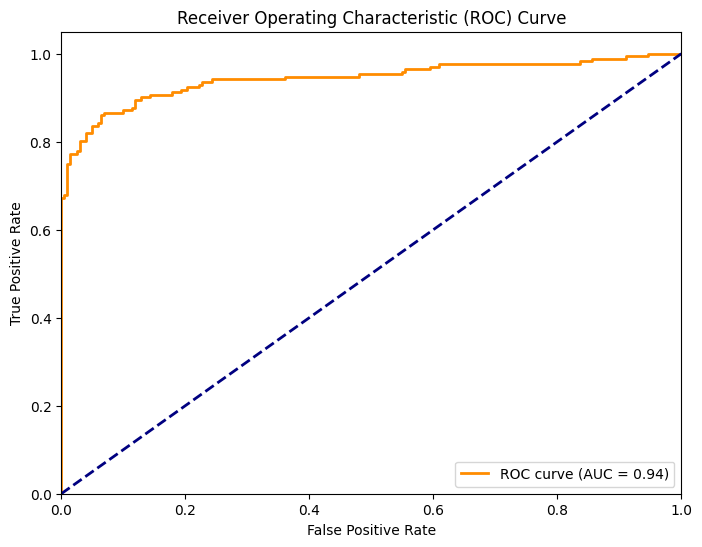

Validation Accuracy: 0.8820

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90       202
         1.0       0.98      0.76      0.86       171

    accuracy                           0.88       373
   macro avg       0.90      0.87      0.88       373
weighted avg       0.90      0.88      0.88       373

ROC AUC Score: 0.9431
Model saved successfully.


In [7]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set up paths and load data
base_dir = "C:\\Users\\User\\Documents\\FTL_Capstone_Project\\FTL_Cohort3_Group10"
train_dir = os.path.join(base_dir, "data", "training")
downloaded_dir = os.path.join(base_dir, "downloaded_images_2")
processed_dir = os.path.join(base_dir, "processed_images")
train_labels_file = os.path.join(base_dir, "data", "labels_training.csv")

# Load labels
train_labels_df = pd.read_csv(train_labels_file)
train_labels_df['id'] = train_labels_df['id'].astype(str)

# 2. Image preprocessing function
def process_image(file_path):
    # Read the image
    img = cv2.imread(file_path)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for red color
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    
    lower_red = np.array([170, 120, 70])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)
    
    # Combine masks
    mask = mask1 + mask2
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Crop the image
        cropped = img[y:y+h, x:x+w]
        
        # Remove red lines
        hsv_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
        mask_cropped = cv2.inRange(hsv_cropped, lower_red, upper_red)
        mask_cropped = cv2.bitwise_not(mask_cropped)
        result = cv2.bitwise_and(cropped, cropped, mask=mask_cropped)
        
        # Convert back to RGB (from BGR)
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        
        return Image.fromarray(result_rgb)
    else:
        print(f"No red contour found in {file_path}")
        return None

# 3. Process downloaded images
os.makedirs(processed_dir, exist_ok=True)
for filename in os.listdir(downloaded_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        file_path = os.path.join(downloaded_dir, filename)
        processed_image = process_image(file_path)
        if processed_image:
            processed_image.save(os.path.join(processed_dir, f"processed_{filename}"))
        else:
            print(f"Skipping {filename} due to processing error")

print("Image processing complete.")

# 4. Prepare file paths and labels
def get_image_files_and_labels(directory, label_df=None, default_label=None):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                   if (f.startswith('processed_') if directory == processed_dir else True) 
                   and f.lower().endswith(('.tif', '.jpg', '.jpeg', '.png'))]
    if label_df is not None:
        labels = [label_df.loc[label_df['id'] == os.path.splitext(os.path.basename(f))[0], 'label'].values[0] 
                  if os.path.splitext(os.path.basename(f))[0] in label_df['id'].values else None 
                  for f in image_files]
        return [f for f, l in zip(image_files, labels) if l is not None], [l for l in labels if l is not None]
    else:
        return image_files, [default_label] * len(image_files)

image_files, labels = get_image_files_and_labels(train_dir, train_labels_df)
downloaded_files, downloaded_labels = get_image_files_and_labels(processed_dir, default_label=1)

all_image_files = image_files + downloaded_files
all_labels = labels + downloaded_labels

# 5. Split the data
train_files, val_files, train_labels, val_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42
)

# 6. Print sample counts and data balance
print(f"Total images: {len(all_image_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

label_counts = pd.Series(all_labels).value_counts()
print("\nLabel distribution:")
print(label_counts)
print(f"\nData balance (ratio of minority to majority class): {label_counts.min() / label_counts.max():.2f}")

# 7. Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=all_labels)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 8. Print and visualize samples from each dataset
def plot_samples(image_files, labels, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = Image.open(image_files[i]).convert('RGB')
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_samples(train_files, train_labels, "Training Samples")
plot_samples(val_files, val_labels, "Validation Samples")

# 9. Plot image sizes
def get_image_sizes(image_files):
    sizes = []
    for file in image_files:
        with Image.open(file) as img:
            sizes.append(img.size)
    return sizes

all_sizes = get_image_sizes(all_image_files)
widths, heights = zip(*all_sizes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.title('Distribution of Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Print summary statistics of image sizes
size_df = pd.DataFrame(all_sizes, columns=['width', 'height'])
print("\nImage size statistics:")
print(size_df.describe())

# 11. Define data loading and preprocessing function
def load_and_preprocess_image(file_path):
    try:
        with Image.open(file_path) as img:
            img = img.convert('RGB').resize((101, 101))
            img_array = np.array(img).astype(np.float32) / 255.0
        
        grayscale = np.mean(img_array, axis=-1, keepdims=True)
        dx, dy = np.gradient(grayscale[:,:,0])
        edge_magnitude = np.sqrt(dx**2 + dy**2)[..., np.newaxis]
        texture = np.abs(grayscale - np.mean(grayscale))
        
        return np.concatenate([img_array, grayscale, edge_magnitude, texture], axis=-1)
    except (OSError, UnidentifiedImageError):
        print(f"Error loading image: {file_path}")
        return None

def prepare_dataset(file_paths, labels):
    images = []
    valid_labels = []
    for file_path, label in zip(file_paths, labels):
        img = load_and_preprocess_image(file_path)
        if img is not None:
            images.append(img)
            valid_labels.append(label)
    
    if not images:
        print("No valid images found in the dataset.")
        return None
    
    dataset = tf.data.Dataset.from_tensor_slices((np.array(images), np.array(valid_labels, dtype=np.float32)))
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Prepare datasets
train_dataset = prepare_dataset(train_files, train_labels)
val_dataset = prepare_dataset(val_files, val_labels)

# Check if datasets are available before proceeding
if train_dataset is not None and val_dataset is not None:
    # 12. Create and compile the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(101, 101, 6)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 13. Train the model
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

    # 14. Evaluate and predict
    val_loss, val_accuracy = model.evaluate(val_dataset)
    val_predictions = model.predict(val_dataset)
    val_predictions_binary = (val_predictions > 0.5).astype(int)
    val_labels_array = np.concatenate([labels for _, labels in val_dataset])

    # 15. Visualizations for model performance
    # Training History Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix Heatmap
    cm = confusion_matrix(val_labels_array, val_predictions_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Actual vs Predicted Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(val_labels_array, val_predictions.flatten(), alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(val_labels_array, val_predictions)
    roc_auc = roc_auc_score(val_labels_array, val_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 16. Print evaluation metrics
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(val_labels_array, val_predictions_binary))
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # 17. Save the model
    model.save('solar_panel_detection_model.keras')
    print("Model saved successfully.")
else:
    print("Error: Datasets are not available. Please check your data loading process.")

## Solar Panel Size Estimation

In [8]:
# Load the trained model
model = load_model('solar_panel_detection_model.keras')

In [13]:
def detect_solar_panel(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (101, 101))
    img_array = img_to_array(img_resized) / 255.0

    # Convert to grayscale
    grayscale = np.mean(img_array, axis=-1, keepdims=True)
    
    # Calculate edge magnitude
    dx, dy = np.gradient(grayscale[:,:,0])
    edge_magnitude = np.sqrt(dx**2 + dy**2)[..., np.newaxis]
    
    # Calculate texture
    texture = np.abs(grayscale - np.mean(grayscale))
    
    # Concatenate all channels
    img_processed = np.concatenate([img_array, grayscale, edge_magnitude, texture], axis=-1)
    img_expanded = np.expand_dims(img_processed, axis=0)

    # Predict
    prediction = model.predict(img_expanded)
    
    if prediction[0][0] > 0.5:  # Assuming binary classification
        # If solar panel detected, find contours
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Find the largest contour (assuming it's the solar panel)
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            return (x, y, w, h)
    
    return None

In [14]:
def process_images(image_paths, pixels_per_meter):
    results = []
    for path in image_paths:
        size = estimate_size(path, pixels_per_meter)
        if size:
            width, height = size
            results.append((path, width, height))
        else:
            results.append((path, None, None))
    return results

In [15]:
# Use a subset of validation images for size estimation
num_images_to_process = 10  # Adjust this number as needed
image_paths_to_process = val_files[:num_images_to_process]

# Set pixels_per_meter (this needs to be calibrated for your images)
pixels_per_meter = 100  # Example value, adjust based on your image scale

# Process images and estimate sizes
size_estimates = process_images(image_paths_to_process, pixels_per_meter)

# Print results
for path, width, height in size_estimates:
    if width and height:
        print(f"Image: {path}")
        print(f"Estimated size: {width:.2f}m x {height:.2f}m")
    else:
        print(f"Image: {path}")
        print("No solar panel detected or size estimation failed.")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: C:\Users\User\Documents\FTL_Capstone_Project\FTL_Cohort3_Group10\data\training\1207.tif
No solar panel detected or size estimation failed.

Image: C:\Users\User\Documents\FTL_Capstone_Project\FTL_Cohort3_Group10\data\training\1402.tif
No solar panel detected or size estimation failed.

Image: C:\Users\User\Documents\FTL_Capstone_Project\FTL_Cohort3_Group10\data\training\308.tif
No solar panel detected or size estimation failed.

Image: C:\Users\User\Documents\FTL_Capstone_Project\FTL_Cohort3_Group10\data\training\741.tif
No solar panel detected or size estimation failed.

Image: C:\Users\User\Documents\FTL

In [16]:
def visualize_detection(image_path):
    img = cv2.imread(image_path)
    dimensions = detect_solar_panel(image_path)
    if dimensions:
        x, y, w, h = dimensions
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Solar Panel")
        plt.axis('off')
        plt.show()
    else:
        print("No solar panel detected in this image.")

# Visualize a few detections
for path in image_paths_to_process[:5]:  # Visualize first 5 processed images
    visualize_detection(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
No solar panel detected in this image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
No solar panel detected in this image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
No solar panel detected in this image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
No solar panel detected in this image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
No solar panel detected in this image.


   ## Baseline Models Comparison

In [8]:


# 1. Function to extract HOG features
def extract_hog_features(image_path):
    image = Image.open(image_path).convert('L').resize((128, 128))
    image = np.array(image)
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# 2. Prepare data
X = np.array([extract_hog_features(file) for file in all_image_files])
y = np.array(all_labels)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, lr_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_prob):.4f}\n")

# 6. K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_prob = knn_model.predict_proba(X_test_scaled)[:, 1]

print("K-Nearest Neighbors Results:")
print(classification_report(y_test, knn_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, knn_prob):.4f}\n")

# 7. Random Forest (additional suggested model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_prob):.4f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       202
           1       0.64      0.68      0.66       171

    accuracy                           0.68       373
   macro avg       0.68      0.68      0.68       373
weighted avg       0.68      0.68      0.68       373

ROC AUC Score: 0.7574

K-Nearest Neighbors Results:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       202
           1       0.84      0.51      0.64       171

    accuracy                           0.73       373
   macro avg       0.76      0.72      0.71       373
weighted avg       0.76      0.73      0.72       373

ROC AUC Score: 0.8102

Random Forest Results:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       202
           1       0.69      0.54      0.61       171

    accuracy                           0.68       373
 